## 1- Dependencies

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Input, Embedding, Bidirectional, LSTM, Attention, Conv1D, GlobalMaxPooling1D, Dense
from keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2- Data

In [5]:
train = pd.read_csv(
    "/content/drive/MyDrive/Data/train.csv"
)

In [6]:
train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [7]:
for col in train.columns[2:]:
    print(train[col].value_counts(), "-" * 40, sep="\n")

# - Unbalanced data

0    144277
1     15294
Name: toxic, dtype: int64
----------------------------------------
0    157976
1      1595
Name: severe_toxic, dtype: int64
----------------------------------------
0    151122
1      8449
Name: obscene, dtype: int64
----------------------------------------
0    159093
1       478
Name: threat, dtype: int64
----------------------------------------
0    151694
1      7877
Name: insult, dtype: int64
----------------------------------------
0    158166
1      1405
Name: identity_hate, dtype: int64
----------------------------------------


In [8]:
test = pd.read_csv(
    "/content/drive/MyDrive/Data/test.csv"
)

In [9]:
test.tail()

,id,comment_text
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


In [10]:
test_label = pd.read_csv(
    "/content/drive/MyDrive/Data/test_labels.csv"
)

In [11]:
test_label.tail()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1
153163,ffffce3fb183ee80,-1,-1,-1,-1,-1,-1


## 3- Preprocess

### 3.1- Data Cleaning

In [13]:
def clean(text: str) -> str:
    '''
        Remove Common English Stopwords
    '''
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in text.split() if word not in stop_words]
    text = " ".join(tokens)
    return text

In [14]:
x_train = train["comment_text"].str.lower()\
    .str.replace("\xa0", " ", regex=False)\
    .str.split().str.join(" ").fillna("fillna").apply(clean)

x_test = test["comment_text"].str.lower()\
    .str.replace("\xa0", " ", regex=False)\
    .str.split().str.join(" ").fillna("fillna").apply(clean)

In [15]:
y_train = train[train.columns[2:]].values

y_test = test_label[test_label.columns[1:]].replace(-1, 1).values

### 3.2- Tokenize + Pad

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [17]:
MAX_FEATURES = len(tokenizer.word_index)
lengths = [len(s) for s in x_train]

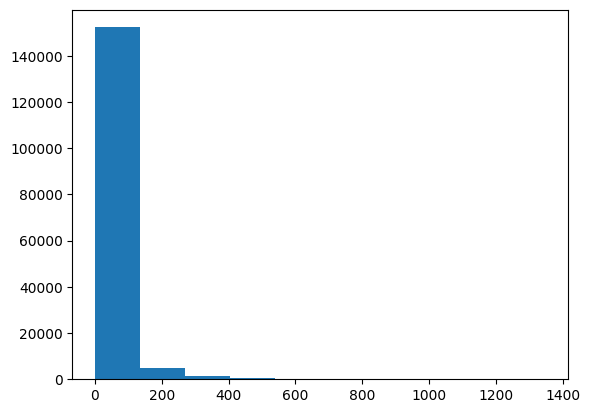

In [18]:
plt.hist(lengths, bins=10)
plt.show()

In [19]:
x_train = pad_sequences(x_train, maxlen=150, padding="post", truncating="post")
x_test = pad_sequences(x_test, maxlen=150, padding="post",truncating="post")

## 4- Model

In [20]:
input_layer = Input(shape=(150,))

embedding_layer = Embedding(MAX_FEATURES + 1, 128)(input_layer)

lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3))(embedding_layer)
attention = Attention()([lstm_layer, lstm_layer])

conv1d_layer = Conv1D(64, kernel_size=3, activation="relu")(attention)
max_pooling_layer = GlobalMaxPooling1D()(conv1d_layer)

dense_layer = Dense(128, activation="relu")(max_pooling_layer)
output_layer = Dense(6, activation="sigmoid")(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 150, 128)             2683238   ['input_1[0][0]']             
                                                          4                                       
                                                                                                  
 bidirectional (Bidirection  (None, 150, 256)             263168    ['embedding[0][0]']           
 al)                                                                                              
                                                                                              

In [22]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
checkpoint_path = "/content/drive/MyDrive/best_model.ckpt"
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [26]:
early_stop_callback = EarlyStopping(
    monitor = "val_loss",
    patience = 3,
    verbose = True
)

In [27]:
history = model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1, callbacks=[checkpoint_callback, early_stop_callback])

Epoch 1/2
1122/1122 [==============================] - 4506s 4s/step - loss: 0.0881 - accuracy: 0.9652 - val_loss: 0.0519 - val_accuracy: 0.9940
Epoch 2/2
1122/1122 [==============================] - 4408s 4s/step - loss: 0.0450 - accuracy: 0.9937 - val_loss: 0.0498 - val_accuracy: 0.9940


In [28]:
model.load_weights(checkpoint_path)

In [34]:
model.save("/content/drive/MyDrive/bilstmconv.keras")

## 5- Evaluate Model

In [31]:
loss, accuracy = model.evaluate(x_test, y_test)

4787/4787 [==============================] - 873s 182ms/step - loss: 3.5979 - accuracy: 0.9990
